## Initial Cleaning

In [37]:
## mostly unused modules
import cv2, matplotlib as mpl, matplotlib.image as mpimg, \
       matplotlib.pyplot as plt, multiprocessing, numpy as np, \
       os, pandas as pd, PIL, PIL.Image, random, shutil, swifter, sys
from functools             import partial
from tqdm                  import tqdm
## data from: https://www.kaggle.com/datasets/tapakah68/medical-masks-part1
## https://www.geeksforgeeks.org/python-pil-paste-and-rotate-method/
## https://towardsdatascience.com/loading-custom-image-dataset-for-deep-learning-models-part-1-d64fa7aaeca6

tqdm.pandas()
img_folder = r'facemasks\images'
facemask_imgs = [i for i in os.listdir(img_folder) if i.endswith('.jpg')]

def check_img_exists(path, files = facemask_imgs):
    if path in files:
        return 1
    else:
        return 0

def get_img_dims(path, folder_path = img_folder, aspect_ratio = True):
    npath = os.path.join(folder_path, path)
    try:
        h, w, _ = cv2.imread(npath).shape
        if aspect_ratio:
            l = img.shape[1]
            w = img.shape[0]
            return w / h
        else:
            return [w, h]
    except:
        return [np.nan]

## Creating DataFrames

In [38]:
facemasks = pd.concat([pd.read_csv('/facemasks/' + i) for i in \
                       os.listdir('/facemasks') if i.startswith('df')])\
              .drop(columns = 'ID').reset_index(drop = True)
facemasks.columns   = facemasks.columns.str.lower()
facemasks = facemasks.replace({'gender': {'NONE': 2, 'MALE': 0, 'FEMALE': 1}, \
                               'type':   {1: 0, 2: 1, 3: 1, 4: 2}})
facemasks['exists'] = facemasks['name'].swifter.progress_bar(True)\
                                       .apply(lambda x: check_img_exists(x))

Pandas Apply:   0%|          | 0/200000 [00:00<?, ?it/s]

In [40]:
## remove filenames for files not found
facemasks = facemasks[facemasks['exists'] == 1].drop(columns = 'exists')
facemasks = facemasks.replace({'gender': {2: np.nan}})
facemasks.to_csv('facemasks/labels.csv')
facemasks.describe()

,type,user_id,gender,age,size_mb
count,199698.000000,199698.000000,152500.000000,199698.000000,199698.000000
mean,1.000075,10577.735921,0.360787,29.078058,2.158958
std,0.707144,7298.009062,0.480230,39.782224,1.507950
min,0.000000,1.000000,0.000000,18.000000,0.005564
25%,1.000000,3913.000000,0.000000,22.000000,1.157589
50%,1.000000,9759.000000,0.000000,26.000000,1.747632
75%,2.000000,16696.000000,1.000000,33.000000,2.772778
max,2.000000,24715.000000,1.000000,2020.000000,32.023958


In [57]:
facemasks = pd.read_csv('facemasks/labels.csv', low_memory = False)\
              .drop(columns = ['Unnamed: 0'])
facemasks.index.name = 'id'

new_folder_0 = os.path.join(img_folder, 'type_0')
new_folder_1 = os.path.join(img_folder, 'type_1')
new_folder_2 = os.path.join(img_folder, 'type_2')

try:
    os.mkdir(new_folder_0, 0o666)
    os.mkdir(new_folder_1, 0o666)
    os.mkdir(new_folder_2, 0o666)
except:
    print('Already created new folders!')
    
def gender_to_letter(gender):
    if   gender == 0.0:
        return 'M'
    elif gender == 1.0:
        return 'F'
    else:
        return 'N'
    
new_folder_paths = []
for idx, row in tqdm(facemasks.iterrows()):
    new_path = '{:05}_{}_{}_{}.jpg'
    new_path = new_path.format(row['user_id'], row['type'], \
                               gender_to_letter(row['gender']), \
                               row['age'])
    new_path = os.path.join(img_folder, 'type_{}'.format(row['type']), new_path)
    old_path = os.path.join(img_folder, row['name'])
    new_folder_paths.append([idx, new_path])
    
    try:
        shutil.move(old_path, new_path)
    except:
        pass

facemasks = pd.concat([facemasks, pd.DataFrame(new_folder_paths, \
                                               columns = ['id', 'new_paths'])\
                                    .set_index('id')], axis = 1)
facemasks.to_csv('facemasks/labels.csv')
print('Images moved to classifying folders!')

Already created new folders!


199698it [36:37, 90.88it/s] 


Images moved to classifying folders!


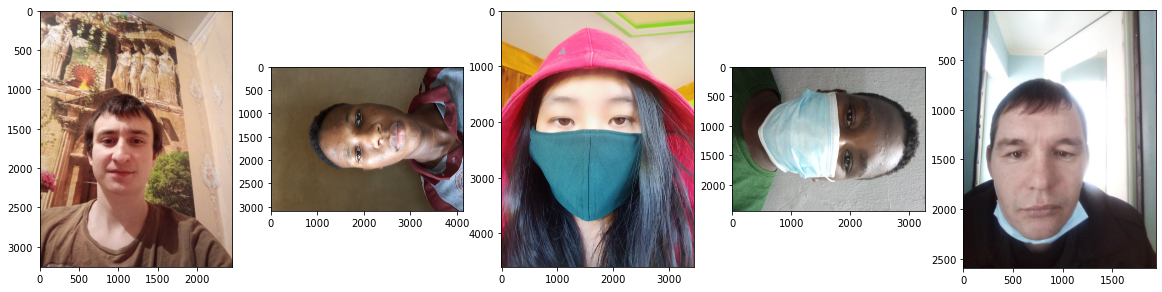

In [59]:
plt.figure(figsize = (20, 20))
for i in range(5):
    file = random.choice(facemasks['new_paths'].values)
    # image_path = os.path.join(new_folder, file)
    img  = mpimg.imread(file)
    ax   = plt.subplot(1, 5, i + 1)
    # ax.title.set_text(file)
    plt.imshow(img)